In [1]:
# draw a line plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
# previous meta data
per_layer_per_sample_infer_time = 0.01
per_layer_load_time = 0.1
batch_size = 8

In [3]:
def calculate_throughputs(device, modality, layer_num, data, type="ours"):
    # Define the throughput calculation function
    def calculate_throughput(pspl, layer_load_quantize, batch_size, layer_num):
        return batch_size / (layer_num * max(pspl * batch_size, layer_load_quantize) + layer_load_quantize)
    if type == "baseline":
        def calculate_throughput(pspl, layer_load_quantize, batch_size, layer_num):
            return batch_size / (layer_num * (pspl * batch_size + layer_load_quantize))

    # Extract the parameters for the specified device and modality
    if device in data and modality in data[device]:
        params = data[device][modality]
        throughput = calculate_throughput(
            params["pspl"], params["layer_load_quantize"], params["batch_size"], layer_num
        )
        return throughput
    else:
        return None  # If the specified device or modality is not found in the data

# Define the data
data = {
    "ORIN": {
        "vision": {"pspl": 0.00129, "layer_load_quantize": 0.0149460463, "batch_size": 8},
        "audio": {"pspl": 0.001, "layer_load_quantize": 0.0064101858, "batch_size": 4},
        "imu": {"pspl": 0.001313, "layer_load_quantize": 0.0040090541, "batch_size": 4}
    },
    "RPI": {
        "vision": {"pspl": 0.631712, "layer_load_quantize": 0.176157224, "batch_size": 4},
        "audio": {"pspl": 0.317576, "layer_load_quantize": 0.066587185, "batch_size": 4},
        "imu": {"pspl": 0.1894, "layer_load_quantize": 0.0361004, "batch_size": 4}
    },
    "8Gen3": {
        "vision": {"pspl": 0.189874, "layer_load_quantize": 0.43394, "batch_size": 4},
        "audio": {"pspl": 0.2475, "layer_load_quantize": 0.059389, "batch_size": 4}
    }
}

# Example usage
device = "ORIN"  # Specify the device
modality = "vision"  # Specify the modality
layer_num = 1  # Specify the layer number
throughput = calculate_throughputs(device, modality, layer_num, data)

# Display the result
print(f"Throughput for {device} {modality} with layer_num {layer_num}: {throughput}")

Throughput for ORIN vision with layer_num 1: 267.62930608611856


0.4107733975323503


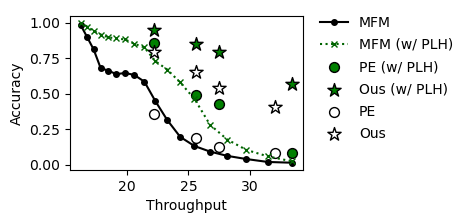

In [9]:
# Ablation study (FLICKR)
normalized_accuracy = 0.6646
normalized_accuracy2 = 0.6917850525015442
zeroshot_path = '../data/result_test_flickr8k_zeroshot.csv'
plora_path = '../data/result_test_flickr8k_plora_s1_e50_ratio3_with_head.csv'
tlora_path = '../data/result_test_flickr8k_tlora_s1_e100_ratio3_without_head.csv'
fig = plt.figure(figsize=(3, 2))
# layer: array 32 to 1 one by one
show_idx = 18
x_layer = np.array(range(32, 0, -1))[:show_idx]
x = [calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array(pd.read_csv(zeroshot_path).iloc[:, 0])[:show_idx] / normalized_accuracy2 # baseline: zeroshot
y1= np.array(pd.read_csv(plora_path).iloc[:, 0])[:show_idx] / normalized_accuracy2 # plora healing. baseline: healing
y2 = np.array(pd.read_csv(tlora_path).iloc[:, 0])[:show_idx] / normalized_accuracy2 # healing with duel plora (tlora)

# display data points
plt.plot(x, y, label='MFM', color='black', linestyle='-', marker='o', markersize=4)
# plt.plot(x, y1, label='Healing EE', color='darkblue', linestyle='--', marker='^', markersize=4)
plt.plot(x, y2, label='MFM (w/ PLH)', color='darkgreen', linestyle=':', marker='x', markersize=4)

# print(np.mean(y2-y1))

# TODO check this 
# Dynamic embedding accuracy.
# Raw data: e2e_lora_e2e_predict_model_flicker.csv
# S = [1, 10, 40], Q = 50
# x_layer = np.array([23.15, 18.4, 14.983])
# x = 1 / (x_layer * per_layer_per_sample_infer_time + per_layer_load_time / batch_size)
# y = np.array([0.24, 0.08, 0.05]) / normalized_accuracy

# y1 = np.array([0.63, 0.52, 0.37]) / normalized_accuracy

# (tmp) Dynamic embedding accuracy. Ground truth
# Raw data: e2e_lora_ground_truth_flicker.csv
# S = [1], Q = 10
x_layer = np.array([23.15,18.4775,14.9883,19.9191])
x = [calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array([0.57,0.2833,0.0543,0.3247]) / normalized_accuracy

y1 = np.array([0.63,0.52686,0.3780,0.567]) / normalized_accuracy

# print(np.mean(y1-y))

# draw a scatter plot
plt.scatter(x, y, label='PE (w/ PLH)', color='green', marker='o', s=50, edgecolors='black')
plt.scatter(x, y1, label='Ous (w/ PLH)', color='green', marker='*', s=100, edgecolors='black')


x_layer = np.array([23.148,19.919,18.478,15.685])
x = [calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array([0.238,0.125,0.083,0.053]) / normalized_accuracy

y1 = np.array([0.529,0.434,0.359,0.269]) / normalized_accuracy
plt.scatter(x, y, label='PE', color='white', marker='o', s=50, edgecolors='black')
plt.scatter(x, y1, label='Ous', color='white', marker='*', s=100, edgecolors='black')

print(np.mean(y1-y))

plt.xlabel('Throughput')
plt.ylabel('Accuracy')

# x-axis log
# plt.xscale('log')

plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), ncol=1, borderaxespad=0, frameon=False, labelspacing=0.6) 
plt.savefig('../figs/eval-ablation-flickr.pdf', bbox_inches='tight')
plt.show()

0.28676363636363633


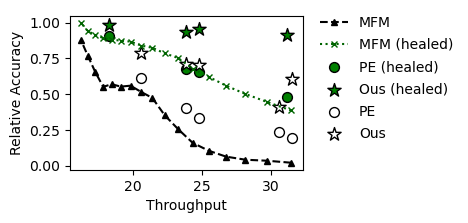

In [15]:
# Ablation study (COCO)
normalized_accuracy = 0.55
normalized_accuracy2 = 0.55
data_path = '../data/imagebind_coco.csv'
fig = plt.figure(figsize=(3, 2))
# layer: array 32 to 1 one by one
show_idx = 15
x_layer = np.array(range(1, 33, 1))[show_idx:]
x =[calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array(pd.read_csv(data_path).iloc[:, 6])[show_idx:] / normalized_accuracy2 # baseline: zeroshot
y1= np.array(pd.read_csv(data_path).iloc[:, 8])[show_idx:] / normalized_accuracy2 # plora healing. baseline: healing
y2 = np.array(pd.read_csv(data_path).iloc[:, 3])[show_idx:] / normalized_accuracy2 # healing with duel plora (tlora)

# display data points
# plt.plot(x, y, label='Zero-shot EE', color='black', linestyle='-', marker='o', markersize=4)
plt.plot(x, y1, label='MFM', color='black', linestyle='--', marker='^', markersize=4)
plt.plot(x, y2, label='MFM (healed)', color='darkgreen', linestyle=':', marker='x', markersize=4)

# 计算y2 y1差值的平均值
# print(np.mean(y2-y1))

# TODO check this 
# Dynamic embedding accuracy.
# Raw data: e2e_lora_e2e_predict_model_flicker.csv
# S = [1, 10, 40], Q = 50
# x_layer = np.array([23.15, 18.4, 14.983])
# x = 1 / (x_layer * per_layer_per_sample_infer_time + per_layer_load_time / batch_size)
# y = np.array([0.24, 0.08, 0.05]) / normalized_accuracy

# y1 = np.array([0.63, 0.52, 0.37]) / normalized_accuracy

# (tmp) Dynamic embedding accuracy. Ground truth max
# Raw data: e2e_coco_lora_test_coco_max.csv
# S = [1], Q = 10
x_layer = np.array([16.1814,21.4118,20.5950,28.2520])
x = [calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array([0.26489,0.3737,0.3620,0.4979]) / normalized_accuracy

y1 = np.array([0.5020,0.5137,0.5276,0.5400]) / normalized_accuracy


# draw a scatter plot
plt.scatter(x, y, label='PE (healed)', color='green', marker='o', s=50, edgecolors='black')
plt.scatter(x, y1, label='Ous (healed)', color='green', marker='*', s=100, edgecolors='black')

x_layer = np.array([21.4118,20.5950,24.9898,15.9584,16.4932])
x =[calculate_throughputs(device, modality, layer_num, data) for layer_num in x_layer]
y = np.array([0.2233,0.182,0.3383,0.107,0.1305]) / normalized_accuracy

y1 = np.array([0.3911,0.3889,0.4337,0.332,0.224]) / normalized_accuracy
plt.scatter(x, y, label='PE', color='white', marker='o', s=50, edgecolors='black')
plt.scatter(x, y1, label='Ous', color='white', marker='*', s=100, edgecolors='black')

print(np.mean(y1-y))

plt.xlabel('Throughput')
plt.ylabel('Relative Accuracy')

plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), ncol=1, borderaxespad=0, frameon=False, labelspacing=0.6) 
plt.savefig('../figs/eval-ablation-coco.pdf', bbox_inches='tight')
plt.show()